In [ ]:
!pip install simpy
!pip install gymnasium
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.2 MB/s eta 0:00:00


In [ ]:
import simpy
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN
import math
from packet import Packet

In [ ]:
class User:
    def __init__(self,id,arrRate,channelCond):
        self.id = id
        self.buffer = []
        self.arrRate = arrRate
        self.channelCond = channelCond

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
numUsers = 2
numRB = 1
buffSize = 10
sizeMean = 12000 #bits
sizeMin = 0.25*sizeMean #64 bytes
sizeMax = 2*sizeMean #64 KB
boundMin = 0.001
boundMax = 0.005
slotTime = 1e-3
arrRateMin = 30 #packets/sec
arrRateMax = 120 #packets/sec
servRateBad = 50*1e6 #256 Mbps
servRateGood = 100*1e6 #512 Mbps
p01= 0.5
p10 = 0.5
maxSlots = 1000
numFeaturesPerPacket = 4
numObservations = 1+numFeaturesPerPacket*numUsers*buffSize

In [ ]:
import time
from gymnasium import spaces
import csv
import os
class QueueSys(gym.Env):
    def __init__(self):
        self.numEpi = 0
        self.simpyEnv = simpy.Environment()
        self.buffer = []
        self.users = []
        self.arrRates = np.random.randint(1000,10000,(numUsers,))
        self.channelConds = np.random.randint(0,1,(numUsers,))
        self.slotInd = 0
        self.numSteps = 0
        self.startTime = 0
        self.nextArrTimes = np.zeros(numUsers)
        self.violations = np.zeros(numUsers)
        self.totPackets = np.zeros(numUsers)
        self.servRates=[servRateBad,servRateGood]
        self.simpyEnv.process(self.slottedTime(slotTime))
        self.server = simpy.Resource(self.simpyEnv,capacity=1)
        self.action_space = spaces.Discrete(buffSize*numUsers)
        self.observation_space = spaces.Box(low=-maxSlots,high=maxSlots,shape=(numObservations,),dtype=np.float32)
        self.totalReward = np.zeros(numUsers)
        self.drop = np.zeros(numUsers)
        csvRow = ['Episode','Total Rewards','Total Violations','Total Packets','%Success','%Violated','Time']

        for i in range(numUsers):
            csvRow +=[f'Rewards{i}',f'Violations{i}',f'Packets{i}',f'Drops{i}']
            user = User(i,self.arrRates[i],self.channelConds[i])
            self.nextArrTimes[i] = np.random.exponential(1.0/user.arrRate)
            self.users.append(user)
            self.buffer+=user.buffer
            self.simpyEnv.process(self.arrProcess(self.users[i]))
        self.nextArrTime = np.min(self.nextArrTimes)
        global log_file
        if not os.path.exists(log_file):
            with open(log_file, mode='w') as file:
                writer = csv.writer(file)
                writer.writerow(csvRow)
    def arrProcess(self,user):
        while True:
            yield self.simpyEnv.timeout(self.nextArrTimes[user.id] - self.simpyEnv.now)
            interArr = np.random.exponential(1.0/user.arrRate)
            self.nextArrTimes[user.id] = self.simpyEnv.now + interArr
            self.nextArrTime = np.min(self.nextArrTimes)
            # print(f'Next arrival for user {user.id} = {self.nextArrTimes[user.id]} and minimum next arrival = {self.nextArrTime}')
            if len(user.buffer)<buffSize:
                bound = np.random.uniform(boundMin,boundMax)
                boundSlot = math.ceil(bound/slotTime)
                size = np.random.randint(sizeMin,sizeMax)
                p = Packet(genTime=self.slotInd,bound=boundSlot,size=size,userId=user.id,channelCond=self.channelConds[user.id])
                user.buffer.append(p)
                self.totPackets[user.id]+=1
                # print(f'Packet arrived for user {user.id} at {self.simpyEnv.now} with slotInd = {self.slotInd}')
            else:
                self.drop[user.id]+=1
                # print(f'Buffer Limit Exceeded')
    def slottedTime(self,slotTime):
        while True:
            # print(f'Slot  = {self.slotInd} at {self.simpyEnv.now}')
            yield self.simpyEnv.timeout(slotTime)
            self.slotInd+=1
            for i in range(numUsers):
                #self.channelConds[i] = self.GilbertElliot(self.channelConds[i],p01,p10)
                #self.users[i].channelCond = self.channelConds[i]
                for p in self.users[i].buffer:
                    p.bound-=1
                    #p.channelCond = self.channelConds[i]
                 #print(self.channelConds[i])

                # print(f'channel condition of user {i} = {self.users[i].channelCond}',end=" ")
    def servePacket(self,userId,action):
        p = self.users[userId].buffer[action]
        channelCond = self.users[userId].channelCond
        servTime = p.size/self.servRates[channelCond]
        # print(f'Time before deleting a packet for user {userId} with arrival time,bound,servTime = {(p.arrTime,p.bound,servTime)}  is {self.simpyEnv.now}')
        yield self.simpyEnv.timeout(servTime)
        self.users[userId].buffer.remove(p)
        # print(f'Time after deleting a packet  = {self.simpyEnv.now}')
        if p.arrTime + p.boundFix>=self.slotInd:
            reward = 1
        else:
            reward = 0
            self.violations[userId]+=1
        return reward

#    def counterfacts(self,userId,action):
#        pass
    def step(self,action):
        if self.numSteps ==0:
            self.startTime = time.time()
        userId = math.floor(action/buffSize)
        # print(f'User = {userId}')
        action = action%buffSize
        # print(f'Action = {action}')
        if not self.users[userId].buffer:
            self.simpyEnv.run(self.nextArrTime)
            self.simpyEnv.step()
            reward = 0
        if action<len(self.users[userId].buffer):
            p = self.users[userId].buffer[action]
            # print(f'Trying to delete packet with {(p.arrTime,p.bound,p.size)} at {self.simpyEnv.now}')
            servProc = self.simpyEnv.process(self.servePacket(userId,action))
            reward = self.simpyEnv.run(servProc)
            # print(f'Current Time = {self.simpyEnv.now}')
        else:
            reward =0
        self.numSteps+=1
        self.totalReward[userId]+= reward
        buff = []
        for user in self.users:
            buff += user.buffer
            # print(f'Length of buffer for user {user.id} is {len(user.buffer)}')
        # print(f'The length of the buffer is: {len(buff)}')
        state = self._get_obs(buff,self.slotInd,self.channelConds)
        # print(f'The current state is {state}')
        truncated = False
        terminated = bool(self.numSteps>=maxSlots)

        if terminated:
            self.numEpi+=1
            row = [self.numEpi, np.sum(self.totalReward), np.sum(self.violations), np.sum(self.totPackets),np.sum(self.totalReward)/np.sum(self.totPackets),np.sum(self.violations)/np.sum(self.totPackets),time.time() - self.startTime]
            for i in range(numUsers):
                row+=[self.totalReward[i],self.violations[i],self.totPackets[i],self.drop[i]]
            with open(log_file, mode='a') as file:
                writer = csv.writer(file)
                writer.writerow(row)
        info={}
        return state, reward, terminated, truncated, info
    def _get_obs(self,buffer,slotInd,channelConds):
        state = np.zeros((numObservations), dtype=np.float32)
        # print(f'The shape of state is {state.shape}')
        state[0] = len(buffer)
        for i, p in enumerate(buffer):
            time_until_bound_normalized = (p.arrTime + p.boundFix-slotInd)
            state[1 + i] = time_until_bound_normalized
            # print(f'packetSize = {p.size}')
            service_slots = math.ceil((p.size/self.servRates[channelConds[p.userId]])/slotTime)
            # print(f'service time = {service_time_normalized}')
            # state[0][1 + i] = service_time_normalized
            state[1+len(buffer)+i]  = channelConds[p.userId]
            state[1+2*len(buffer) + i] = service_slots
            state[1+3*len(buffer) + i] = slotInd
        return state
    def reset(self,seed=0,options=None):
        # print(f'Steps = {self.numSteps}')
        # print(f'Total Rewards = {self.totalReward},violations = {self.violations}, , totalPackets = {self.totPackets},sumTotReward = {np.sum(self.totalReward)}, totalViolations = {np.sum(self.violations)}, sumPackets={np.sum(self.totPackets)}')
        # print(f'Resetting')
        super().reset(seed=seed, options=options)
        self.simpyEnv = simpy.Environment()
        self.buffer = []
        self.users = []
        self.arrRates = np.random.randint(1000,10000,(numUsers,))
        self.channelConds = np.random.randint(0,1,(numUsers,))
        self.slotInd = 0
        self.numSteps = 0
        self.nextArrTimes = np.zeros(numUsers)
        self.totPackets = np.zeros(numUsers)
        self.violations = np.zeros(numUsers)
        self.servRates=[servRateBad,servRateGood]
        self.simpyEnv.process(self.slottedTime(slotTime))
        self.server = simpy.Resource(self.simpyEnv,capacity=1)
        self.action_space = spaces.Discrete(buffSize*numUsers)
        self.observation_space = spaces.Box(low=-maxSlots,high=maxSlots,shape=(numObservations,),dtype=np.float32)
        self.totalReward = np.zeros(numUsers)
        self.drop = np.zeros(numUsers)
        for i in range(numUsers):
            user = User(i,self.arrRates[i],self.channelConds[i])
            self.nextArrTimes[i] = np.random.exponential(1.0/user.arrRate)
            self.users.append(user)
            self.buffer+=user.buffer
            self.simpyEnv.process(self.arrProcess(self.users[i]))
        self.nextArrTime = np.min(self.nextArrTimes)
        obs = self._get_obs(self.buffer,self.slotInd,self.channelConds)
        info={}
        return obs,info

In [ ]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_checker import check_env
import os
import numpy as np

# Create the directory for log files if it doesn't exist
os.makedirs('./csvLogs', exist_ok=True)

global log_file

# Training with DQN
for i in range(1):
    log_file = f'./csvLogs/DQNuser{numUsers}_seed{i}.csv'
    np.random.seed(i)
    if os.path.exists(log_file):
        os.remove(log_file)
    que = QueueSys()
    check_env(que, warn=True)
    model = DQN('MlpPolicy', que, verbose=1)
    model.learn(total_timesteps=5)

# Training with PPO
for i in range(1):
    log_file = f'./csvLogs/PPOuser{numUsers}_seed{i}.csv'
    np.random.seed(i)
    if os.path.exists(log_file):
        os.remove(log_file)
    que = QueueSys()
    check_env(que, warn=True)
    model = PPO('MlpPolicy', que, verbose=1)
    model.learn(total_timesteps=5)

# Training with A2C
for i in range(1):
    log_file = f'./csvLogs/A2Cuser{numUsers}_seed{i}.csv'
    np.random.seed(i)
    if os.path.exists(log_file):
        os.remove(log_file)
    que = QueueSys()
    check_env(que, warn=True)
    model = A2C('MlpPolicy', que, verbose=1)
    model.learn(total_timesteps=5)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 471      |
| time/              |          |
|    fps             | 424      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


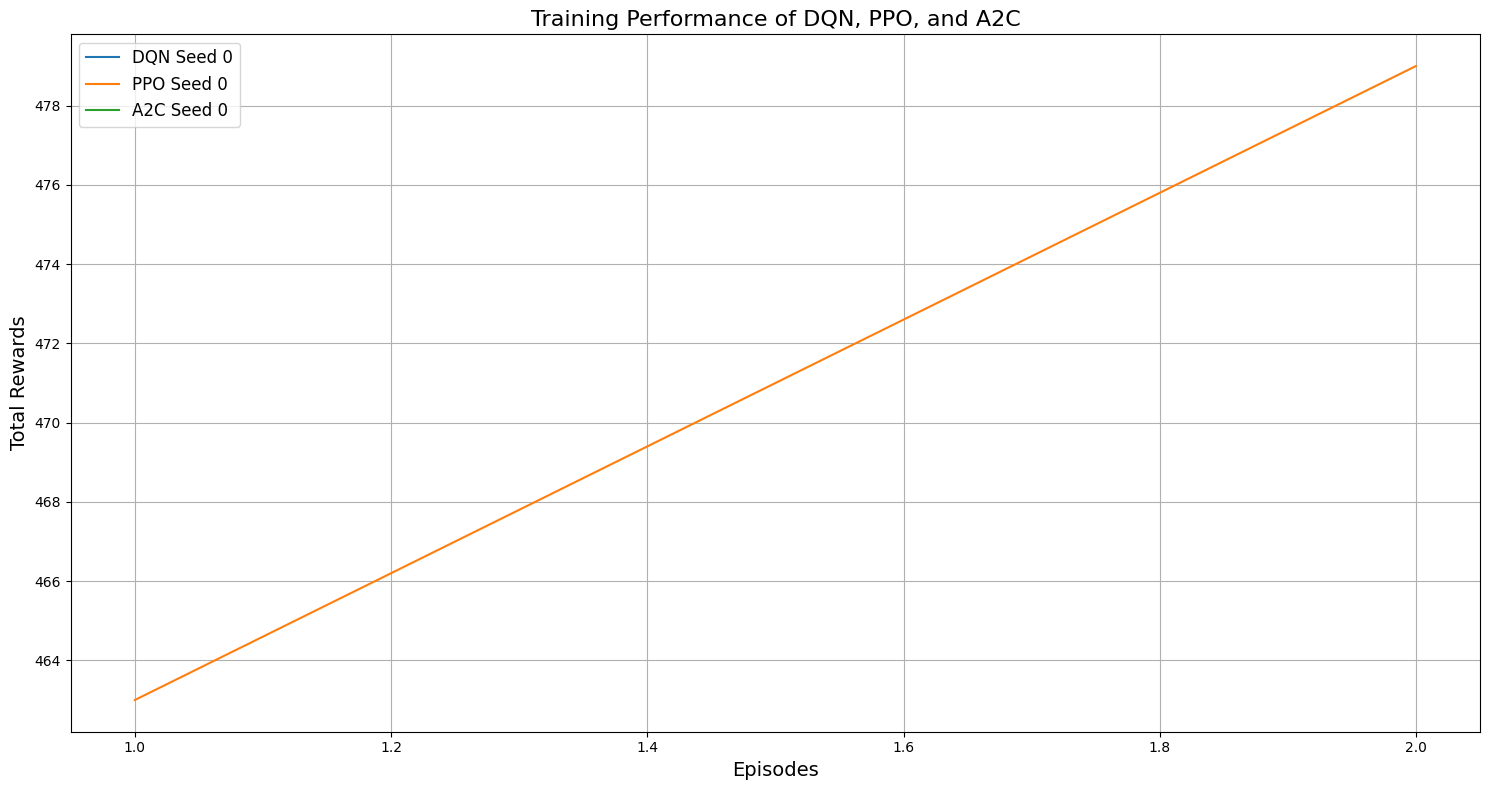

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory containing log files
log_dir = './csvLogs'

# Models and seeds
models = ['DQN', 'PPO', 'A2C']
seeds = range(5)

# Initialize a dictionary to store data
data = {model: [] for model in models}

# Read log files
for model in models:
    for seed in seeds:
        log_file = os.path.join(log_dir, f'{model}user{numUsers}_seed{seed}.csv')
        if os.path.exists(log_file):
            df = pd.read_csv(log_file)
            data[model].append(df)

# Plot cumulative rewards
plt.figure(figsize=(15, 8))
for model in models:
    for i, df in enumerate(data[model]):
        plt.plot(df['Episode'], df['Total Rewards'], label=f'{model} Seed {i}')

plt.title('Training Performance of DQN, PPO, and A2C', fontsize=16)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Total Rewards', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('training_performance.png', dpi=300)

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


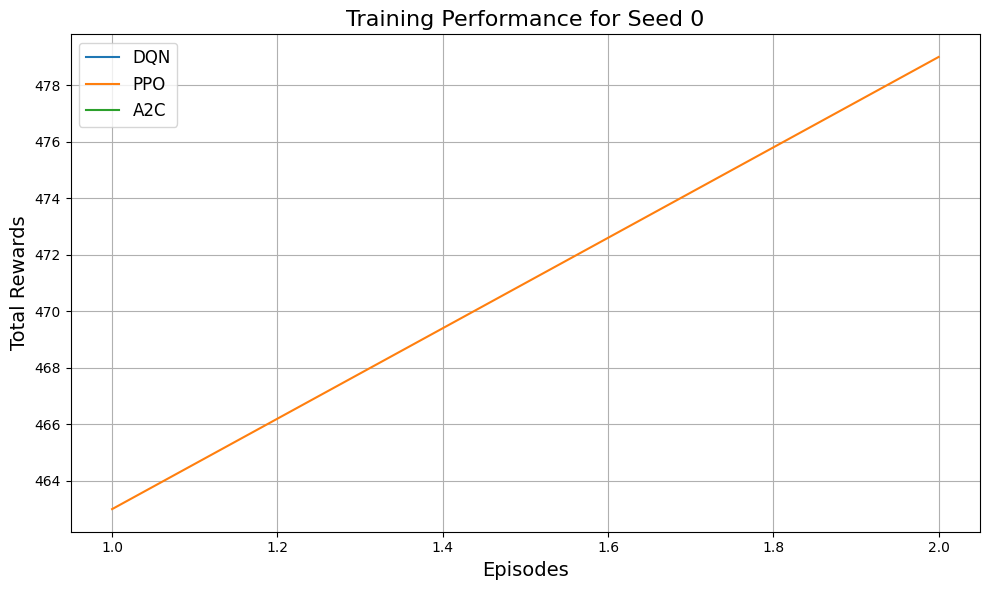

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory containing log files
log_dir = './csvLogs'

# Models
models = ['DQN', 'PPO', 'A2C']
seed = 0  # Focus on a single seed

# Initialize a dictionary to store data
data = {}

# Read log files for each model with the specified seed
for model in models:
    log_file = os.path.join(log_dir, f'{model}user{numUsers}_seed{seed}.csv')
    if os.path.exists(log_file):
        data[model] = pd.read_csv(log_file)

# Plot cumulative rewards for the selected seed
plt.figure(figsize=(10, 6))
for model, df in data.items():
    plt.plot(df['Episode'], df['Total Rewards'], label=model)

plt.title(f'Training Performance for Seed {seed}', fontsize=16)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Total Rewards', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('training_performance_single_seed.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
import pandas as pd

def analyze_logs(algorithm, num_users, num_seeds=5):
    results = []
    for i in range(num_seeds):
        log_file = f'./csvLogs/{algorithm}user{num_users}_seed{i}.csv'
        if os.path.exists(log_file):
            df = pd.read_csv(log_file)
            total_packets = df['Total Packets'].sum()
            total_rewards = df['Total Rewards'].sum()  # Successful packets processed
            success_rate = (total_rewards / total_packets) * 100 if total_packets > 0 else 0
            results.append({
                'Seed': i,
                'Total Packets': total_packets,
                'Processed Without Violation': total_rewards,
                'Success Rate (%)': success_rate
            })
    return pd.DataFrame(results)

# Analyze results for DQN, PPO, A2C
for algo in ['DQN', 'PPO', 'A2C']:
    print(f"Results for {algo}:")
    result_df = analyze_logs(algo, numUsers)
    print(result_df)
    print("\n")


Results for DQN:
   Seed  Total Packets  Processed Without Violation  Success Rate (%)
0     0              0                            0                 0


Results for PPO:
   Seed  Total Packets  Processed Without Violation  Success Rate (%)
0     0         1865.0                        942.0         50.509383


Results for A2C:
   Seed  Total Packets  Processed Without Violation  Success Rate (%)
0     0              0                            0                 0




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
import os

def compute_totals(algorithm, num_users, num_seeds=5):
    total_packets_overall = 0
    total_processed_without_violations = 0

    for i in range(num_seeds):
        log_file = f'./csvLogs/{algorithm}user{num_users}_seed{i}.csv'
        if os.path.exists(log_file):
            df = pd.read_csv(log_file)
            total_packets_overall += df['Total Packets'].sum()
            total_processed_without_violations += df['Total Rewards'].sum()  # Successful packets processed

    return total_packets_overall, total_processed_without_violations

# Compute and print results for each policy
policies = ['DQN', 'PPO', 'A2C']
for policy in policies:
    total_packets, total_processed_without_violations = compute_totals(policy, numUsers)
    print(f"Results for {policy}:")
    print(f"  Total Packets Processed: {total_packets}")
    print(f"  Total Packets Processed Without Violation: {total_processed_without_violations}")
    print("\n")


Results for DQN:
  Total Packets Processed: 0
  Total Packets Processed Without Violation: 0


Results for PPO:
  Total Packets Processed: 1865.0
  Total Packets Processed Without Violation: 942.0


Results for A2C:
  Total Packets Processed: 0
  Total Packets Processed Without Violation: 0




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


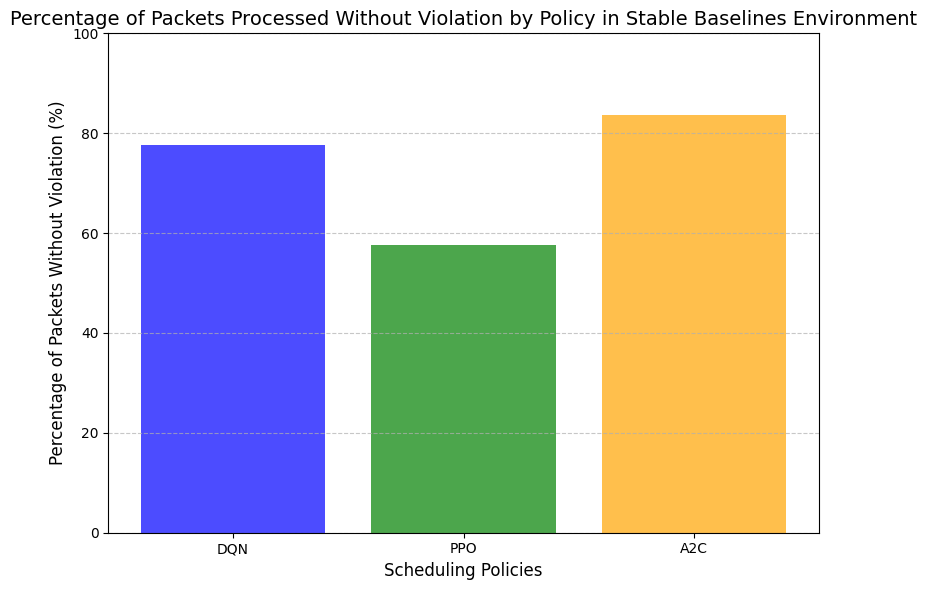

In [ ]:
import matplotlib.pyplot as plt

# Data
policies = ['DQN', 'PPO', 'A2C']
total_packets = [28724.0, 43610.0, 44395.0]
packets_without_violation = [22277.0, 25087.0, 37132.0]

# Calculate percentages
percentages = [(processed / total) * 100 for processed, total in zip(packets_without_violation, total_packets)]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(policies, percentages, color=['blue', 'green', 'orange'], alpha=0.7)
plt.title("Percentage of Packets Processed Without Violation by Policy in Stable Baselines Environment", fontsize=14)
plt.xlabel("Scheduling Policies", fontsize=12)
plt.ylabel("Percentage of Packets Without Violation (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


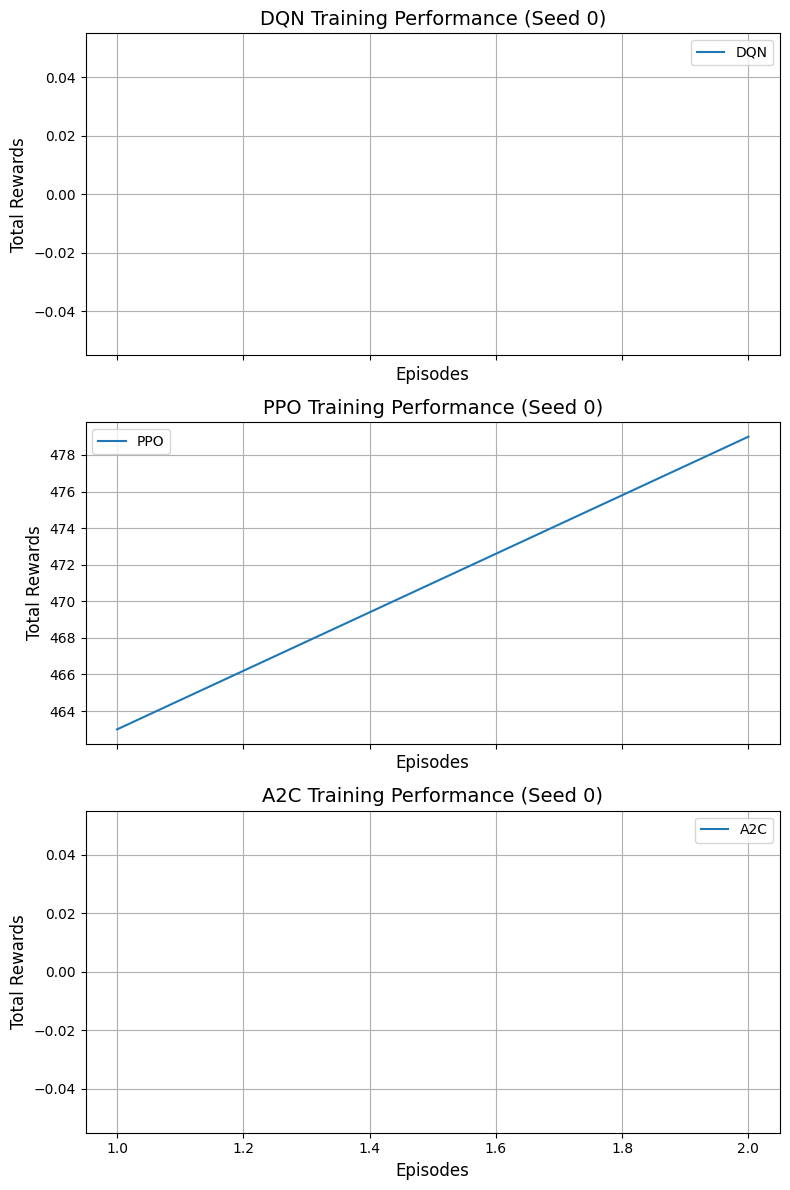

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory containing log files
log_dir = './csvLogs'

# Models
models = ['DQN', 'PPO', 'A2C']
seed = 0  # Focus on a single seed

# Initialize a dictionary to store data
data = {}

# Read log files for each model with the specified seed
for model in models:
    log_file = os.path.join(log_dir, f'{model}user{numUsers}_seed{seed}.csv')
    if os.path.exists(log_file):
        data[model] = pd.read_csv(log_file)

# Create subplots for each model
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True)

# Plot for each model
for idx, (model, df) in enumerate(data.items()):
    axes[idx].plot(df['Episode'], df['Total Rewards'], label=f'{model}', color='tab:blue')
    axes[idx].set_title(f'{model} Training Performance (Seed {seed})', fontsize=14)
    axes[idx].set_xlabel('Episodes', fontsize=12)
    axes[idx].set_ylabel('Total Rewards', fontsize=12)
    axes[idx].legend(loc='best', fontsize=10)
    axes[idx].grid(True)

# Adjust layout
plt.tight_layout()

# Save the combined plot
plt.savefig('training_performance_separate_graphs.png', dpi=300)

# Show the plot
plt.show()
